<a href="https://colab.research.google.com/github/lstarke/wine_sales_forecasting/blob/main/LeandroStarke_Previs%C3%A3o_de_demanda_de_vinhos_com_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREVISÃO DE DEMANDA DE VINHOS

<center><img src="https://drive.google.com/uc?export=view&id=1CvwqPTZceSG3NtE2cOmMVB-3sWtCF2vS" width="80%"></p></center>

# Previsão de demanda

Segundo Mancuzo (2013), previsão de demanda na área de produção de bens tem a
finalidade de predizer o consumo de produtos, de maneira que eles possam ser produzidos antecipadamente e nas quantidades mais próximas da demanda real.

Neste projeto faremos uma análise e previsão de vendas de vinhos contando com o auxílio do framework Prophet.

> Basicamente, a empresa está desenvolvendo uma solução baseada em Machine Learning para ajudar lojas de vinho a fazer uma melhor gestão de seu estoque, o que inclui um modelo que faça previsão de demanda baseado em dados históricos de venda.

Para isso, utilizamos dados históricos de vendas, e levamos outros fatores em consideração para prever qual será a demanda por determinados produtos em um determinado período.








# Instalando pacotes

In [73]:
# instalação de pacotes necessários
!pip install ydata-profiling

# Importando pacotes

In [74]:
# importação dos pacotes necessários
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

from ydata_profiling  import ProfileReport
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from statsmodels.tsa.stattools import adfuller, kpss

# Carregando dados

In [75]:
# importando dados de produtos
df_products = pd.read_csv("https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv")

# imprimindo as 5 primeiras linhas
df_products.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82


In [76]:
# importando dados de vendas
df_sales = pd.read_csv("https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv", parse_dates=["date"])

# imprimindo as 5 primeiras linhas
display(df_sales.head())

,date,store,item,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,11
2,2018-01-03,1,1,14
3,2018-01-04,1,1,13
4,2018-01-05,1,1,10


## Mesclando dados de produto e vendas

In [77]:
# unindo os dataframes de produtos e vendas
df_all = df_sales.merge(df_products, left_on='item', right_on='item_id', how="left").drop(labels="item_id", axis=1) # removendo coluna duplicada item_id

# imprimindo as 5 primeiras linhas
df_all.head()

,date,store,item,sales,name,producer,country,region,vintage,kind,price_brl,price_usd
0,2018-01-01,1,1,13,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2018-01-02,1,1,11,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
2,2018-01-03,1,1,14,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
3,2018-01-04,1,1,13,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
4,2018-01-05,1,1,10,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75


# Analise exploratória dos dados

## Dicionário de variáveis

* ```date```: Data da venda.
* ```store```: Identificador da loja.
* ```item```:	Identificador único de cada vinho.
* ```sales```: Número de unidades vendidas.
* ```name```:	Nome do vinho.
* ```producer```:	Produtor do vinho.
* ```country```:	País de origem do vinho.
* ```region```:	Região de origem do vinho.
* ```vintage```:	Ano de produção do vinho.
* ```kind```: Tipo de vinho
      Sparkling = Espumante
      Rose Sparkling = Espumante Rose
      White = Branco
      Rosé = Rosé
      Red = Tinto
* ```price_brl```:	Preço do vinho em reais.
* ```price_usd```:	Preço do vinho em dólares.





In [78]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720071 entries, 0 to 720070
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       720071 non-null  datetime64[ns]
 1   store      720071 non-null  int64         
 2   item       720071 non-null  int64         
 3   sales      720071 non-null  int64         
 4   name       720071 non-null  object        
 5   producer   720071 non-null  object        
 6   country    720071 non-null  object        
 7   region     720071 non-null  object        
 8   vintage    720071 non-null  object        
 9   kind       720071 non-null  object        
 10  price_brl  720071 non-null  object        
 11  price_usd  720071 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 71.4+ MB


O método info nos mostra que temos um dataframe de 720071 registros e aparentemente nenhum dado nulo.

Além disso, podemos perceber que as colunas de preço (*price_brl* e *price_usd*) são do tipo *object*.

In [79]:
# valores unicos da variavel name
df_all.name.unique()

array(['Philipponnat Royale Reserve Brut',
       'Philipponnat Royale Reserve Rosé',
       'Philipponnat Cuvée 1522 Grand Cru Extra Brut',
       'Philipponnat Cuvée 1522 1er Cru Rosé',
       'Philipponnat Clos Des Goisses Brut',
       'Agrapart & Fils 7 Crus Brut',
       'Agrapart & Fils Terroirs Blanc de Blancs Grand Cru Extra-Brut',
       'Agrapart Minéral Blanc de Blancs Grand Cru Extra-Brut',
       'Agrapart Avizoise Blanc de Blancs Grand Cru Extra-Brut',
       'Zind-Humbrecht Gewurztraminer Hengst Grains Nobles Grand Cru - 375ml',
       'Vacheron Sancerre Blanc', 'Vacheron Sancerre Les Romains',
       'Vacheron Sancerre L’enclos des Remparts Franc de Pied',
       'Nicolas Joly La Roche Aux Moines Clos de La Bergerie',
       'Nicolas Joly Clos de La Coulee De Serrant', 'Mirabeau Classic',
       'Mirabeau Pure', 'Mirabeau Pure - 1,5L (Magnum)',
       'Mirabeau Etoile', 'Triennes Les Aureliens Rouge',
       'Domaine Elian Da Ros Coucou Blanc',
       'Domaine Elian Da

In [80]:
# valores unicos da variavel producer
list(df_all.producer.unique())

['Philipponat',
 'Agrapart',
 'Domaine Zind-Humbrecht',
 'Domaine Vacheron',
 'Nicolas JOLY',
 'Mirabeau',
 'Triennes',
 'Elian da Ros',
 'La Chablisienne',
 'Domaine Paul Pillot',
 'Domaine Michel Niellon',
 'Domaine Alain Chavy',
 'Domaine Matrot',
 'Antoine Jobard',
 'Domaine Tessier',
 'Domaine Pascal Prunier-Bonheur',
 'Domaine Fourrier',
 'Domaine Denis Mortet',
 'Domaine Duroché',
 'Domaine Hudelot-Noellat',
 'Domaine Berthaut-Gerbet',
 'Domaine Dujac',
 'Domaine Ponsot',
 'Stephane Ogier',
 'Domaine de Fontbonau',
 'Eric Texier',
 'Chateau Potensac',
 'Chateau Montrose',
 'Chateau Latour',
 'Chateau Pichon Longueville Comtesse de Lalande',
 'Chateau Leoville Las Cases',
 'Clos du Marquis',
 'Chateau Leoville Barton',
 'Chateau Talbot',
 'Chateau Ducru Beaucaillou',
 'Chateau Gloria',
 "Chateau D'Issan",
 'Chateau Larrivet Haut-Brion',
 'Chateau Pavie',
 'Chateau Trotanoy',
 'Chateau Nenin',
 'Chateau Marjosse',
 'Chateau Climens',
 'Chateau Doisy-Vedrines',
 'Astoria Wines',
 '

In [81]:
# valores unicos da variavel producer
df_all.country.unique()

array(['France', 'Italy', 'Spain', 'Portugal', 'Chile', 'Argentina'],
      dtype=object)

In [82]:
# valores unicos da variavel region
df_all.region.unique()

array(['Champagne', 'Alsace', 'Loire Valley', 'Provence', 'Sud Ouest',
       'Burgundy', 'Rhone', 'Bordeaux', 'Veneto', 'Toscana', 'Piedmont',
       'Campania', 'Puglia', 'Penedès', 'Navarra', 'Rioja',
       'Ribera del Duero', 'Douro', 'Alentejo', 'Maipo', 'Mendoza'],
      dtype=object)

In [83]:
# valores unicos da variavel vintage
df_all.vintage.unique()

array(['NV', '2009', '2008', '2013', '2019', '2018', '2014', '2016',
       '2015', '2017', '2003', '2004', '2007', '2011', '2012', '2002',
       '2010'], dtype=object)

Na variável *vintage* temos a informação do ano que a uva, utilizada para fazer o vinho, foi colhida.

Temos dois pontos de atenção nesta coluna:
1. A coluna é do tipo *object* e poderia ser *integer*;
2. Temos dados com a informação *NV* que significa *Non*Vintage*

In [84]:
# contagem dos valores da variavel vintage
(df_all.vintage.value_counts() / df_all.shape[0]) * 100

2018    29.680268
2017    22.374460
2015     8.675811
2014     8.675811
2016     7.762568
2019     5.479460
NV       3.652973
2013     2.739730
2011     2.739730
2012     2.283108
2003     1.369865
2009     0.913243
2008     0.913243
2004     0.913243
2010     0.913243
2007     0.456622
2002     0.456622
Name: vintage, dtype: float64

Valores *Non-Vintage* representam 3.65% dos dados em nosso DataFrame.

Vamos converter os valores NV (*non-vintage*) para o valor 0 (zero) e alterar o tipo da coluna para integer.

In [85]:
# substituindo valor NV para 0 na coluna vintage
df_all.vintage.replace("NV", 0, inplace=True)

# convertendo tipo da coluna vintage para integer
df_all.vintage = df_all.vintage.astype(int)

In [86]:
# contagem dos valores da variavel vintage
display((df_all.vintage.value_counts() / df_all.shape[0]) * 100)

2018    29.680268
2017    22.374460
2015     8.675811
2014     8.675811
2016     7.762568
2019     5.479460
0        3.652973
2013     2.739730
2011     2.739730
2012     2.283108
2003     1.369865
2009     0.913243
2008     0.913243
2004     0.913243
2010     0.913243
2007     0.456622
2002     0.456622
Name: vintage, dtype: float64

In [87]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720071 entries, 0 to 720070
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       720071 non-null  datetime64[ns]
 1   store      720071 non-null  int64         
 2   item       720071 non-null  int64         
 3   sales      720071 non-null  int64         
 4   name       720071 non-null  object        
 5   producer   720071 non-null  object        
 6   country    720071 non-null  object        
 7   region     720071 non-null  object        
 8   vintage    720071 non-null  int64         
 9   kind       720071 non-null  object        
 10  price_brl  720071 non-null  object        
 11  price_usd  720071 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 71.4+ MB


Como pode ser visto acima, temos os valores *NV* alterados para 0 (zero) e o tipo para *integer* na coluna vintage.

In [88]:
# valores unicos da variavel kind
df_all.kind.unique()

array(['sparkling', 'rose sparkling', 'white', 'rose', 'red'],
      dtype=object)

In [89]:
list(df_all.price_brl.unique())

['339.60',
 '489.00',
 '789.00',
 '899.40',
 '1,548.00',
 '659.40',
 '814.80',
 '1,199.40',
 '1,499.40',
 '459.00',
 '254.40',
 '409.20',
 '1,794.00',
 '539.40',
 '785.40',
 '115.20',
 '135.60',
 '285.00',
 '159.60',
 '125.40',
 '299.40',
 '139.80',
 '269.40',
 '389.40',
 '99.60',
 '175.80',
 '235.80',
 '249.60',
 '509.40',
 '549.60',
 '289.30',
 '619.20',
 '999.00',
 '419.40',
 '359.40',
 '689.40',
 '949.20',
 '996.00',
 '1,392.00',
 '798.00',
 '799.20',
 '1,299.00',
 '719.40',
 '1,029.60',
 '349.20',
 '449.40',
 '219.60',
 '425.40',
 '3,390.00',
 '945.00',
 '2,796.00',
 '199.20',
 '339.00',
 '399.00',
 '3,294.00',
 '1,458.00',
 '2,550.00',
 '3,792.00',
 '5,994.00',
 '5,292.00',
 '10,992.00',
 '599.40',
 '229.20',
 '165.00',
 '289.20',
 '290.20',
 '259.20',
 '319.20',
 '169.20',
 '649.20',
 '299.30',
 '369.60',
 '1,698.00',
 '2,892.00',
 '9,594.00',
 '669.60',
 '2,094.00',
 '2,190.00',
 '459.60',
 '679.20',
 '2,394.00',
 '849.60',
 '559.80',
 '199.80',
 '559.20',
 '569.40',
 '225.60',

In [90]:
list(df_all.price_usd.unique())

['58.75',
 '84.60',
 '136.51',
 '155.61',
 '267.82',
 '114.08',
 '140.97',
 '207.51',
 '259.41',
 '79.41',
 '44.01',
 '70.80',
 '310.38',
 '93.32',
 '135.88',
 '19.93',
 '23.46',
 '49.31',
 '27.61',
 '21.70',
 '51.80',
 '24.19',
 '46.61',
 '67.37',
 '17.23',
 '30.42',
 '40.80',
 '43.18',
 '88.13',
 '95.09',
 '50.05',
 '107.13',
 '172.84',
 '72.56',
 '62.18',
 '119.27',
 '164.22',
 '172.32',
 '240.83',
 '138.06',
 '138.27',
 '224.74',
 '124.46',
 '178.13',
 '60.42',
 '77.75',
 '37.99',
 '73.60',
 '586.51',
 '163.49',
 '483.74',
 '34.46',
 '58.65',
 '69.03',
 '569.90',
 '252.25',
 '441.18',
 '656.06',
 '1,037.02',
 '915.57',
 '1,901.73',
 '103.70',
 '39.65',
 '28.55',
 '50.03',
 '50.21',
 '44.84',
 '55.22',
 '29.27',
 '112.32',
 '51.78',
 '63.94',
 '293.77',
 '500.35',
 '1,659.86',
 '115.85',
 '362.28',
 '378.89',
 '79.52',
 '117.51',
 '414.19',
 '146.99',
 '96.85',
 '34.57',
 '96.75',
 '98.51',
 '39.03',
 '1,037.96',
 '759.86',
 '684.08',
 '120.93',
 '25.22',
 '12.87',
 '16.51',
 '17.13

Verificando os valores unicos em *price_brl* e *price_usd*, percebemos a presença da vírgula (,) nos valores dos preços.

Vamos remover as vírgular e transformar estas colunas para o tipo float.

In [91]:
# removendo as vírgulas das colunas de preço
df_all.replace(',','', regex=True, inplace=True)

In [92]:
# alterando o tipo de string para float nas colunas de preço
df_all[["price_brl", "price_usd"]] = df_all[["price_brl", "price_usd"]].astype("float")

# imprimindo as 5 primeiras linhas
df_all.head()

,date,store,item,sales,name,producer,country,region,vintage,kind,price_brl,price_usd
0,2018-01-01,1,1,13,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75
1,2018-01-02,1,1,11,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75
2,2018-01-03,1,1,14,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75
3,2018-01-04,1,1,13,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75
4,2018-01-05,1,1,10,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75


In [93]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720071 entries, 0 to 720070
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       720071 non-null  datetime64[ns]
 1   store      720071 non-null  int64         
 2   item       720071 non-null  int64         
 3   sales      720071 non-null  int64         
 4   name       720071 non-null  object        
 5   producer   720071 non-null  object        
 6   country    720071 non-null  object        
 7   region     720071 non-null  object        
 8   vintage    720071 non-null  int64         
 9   kind       720071 non-null  object        
 10  price_brl  720071 non-null  float64       
 11  price_usd  720071 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 71.4+ MB


### Identificando GAPS na coluna *date*

In [94]:
# ordenando DataFrame pelas datas
df_all.sort_values("date", inplace=True)

# resetando o index
df_all.reset_index(inplace=True, drop=True)

# identificando linhas que tenham gaps maiores que 1 dia
# e adicionando nova coluna booleana para identificar quais linha tem gaps
df_all['gap'] = df_all['date'].diff() > pd.to_timedelta('1 day')

In [95]:
# imprimindo somente as linhas que possuem gaps entre datas (maiores que 1 dia)
df_all[df_all.gap]

,date,store,item,sales,name,producer,country,region,vintage,kind,price_brl,price_usd,gap
149,2018-01-01,3,85,23,Domaine Ponsot Morey Saint Denis 1er Cru Cuvee...,Domaine Ponsot,France,Burgundy,2017,red,1458.0,252.25,True


Podemos ver abaixo que temos um salto de 2016-01-01 para 2018-01-01.

In [96]:
df_all.iloc[[148, 149]].date

148   2016-01-01
149   2018-01-01
Name: date, dtype: datetime64[ns]

## Verificando quantidade de itens vendidos por data

Como o objetivo deste projeto é fazer uma previsão de demandas, vamos dar uma olhada na coluna *sales* (quantidade de vinhos vendidos em determinada data).

Como iremos utilizar o Prophet para construir este modelo, vamos iniciar adequando o nosso dataframe para Prophet.

In [97]:
# selecionando somente as colunas date e sales
df_prophet = df_all[["date", "sales"]]

# listando os 5 primeiros registros
df_prophet.head()

,date,sales
0,2016-01-01,64
1,2016-01-01,39
2,2016-01-01,39
3,2016-01-01,67
4,2016-01-01,54


In [98]:
print(f"Primeira entrada: {df_prophet.date.min()}")
print(f"Última entrada: {df_prophet.date.max()}")

Primeira entrada: 2016-01-01 00:00:00
Última entrada: 2020-12-31 00:00:00


# Preparação dos dados

Para o Porphet precisamos de somente duas colunas para criarmos o nosso modelo, a coluna de data e a nossa variável target, neste caso, a quantidade de vendas realizadas.

Além disso, nossa coluna de data precisa ser o index do nosso DataFrame.

In [99]:
# setando a coluna DateTime como index do DataFrame
df_prophet.set_index("date", inplace=True, drop=True)

# ordenando DataFrame por data
df_prophet.sort_index(inplace=True)

# imprimindo as 5 primeiras entradas
df_prophet.head()

,sales
date,
2016-01-01,64
2016-01-01,39
2016-01-01,39
2016-01-01,67
2016-01-01,54


In [100]:
# Somando todas as vendas realizadas em 1 dia
df_prophet_daily = df_prophet.resample("D").sum()

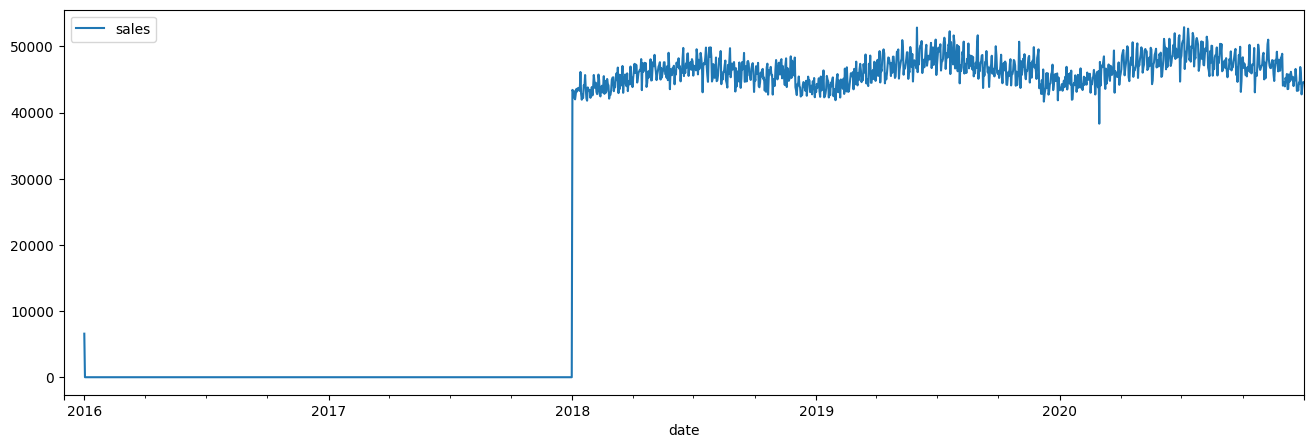

In [101]:
# plotando a frequencia das vendas
fig, ax = plt.subplots(figsize=(16,5))
df_prophet_daily.plot(ax=ax)
ax.set_xlim([dt.date(2015, 12, 1), dt.date(2020, 12, 31)])
plt.show()

No gráfico acima podemos ver um gap que temos entre as datas de 2016-01-02 até 2017-12-1, com zero vendas.

Como temos um salto temporal de 2016-01-01 para 2018-01-01, iremos eliminar este ponto isolado do nosso dataset (2016-01-01) e trabalhar somente com os dados do dataset a partir de 2018-01-01.

In [102]:
# selecionando todos os dados a partir do ano de 2018
df_prophet = df_prophet.loc["2018":]

In [103]:
# somando a quantidade de vendas por dia
df_prophet_daily = df_prophet.resample("D").sum().reset_index()

# renomeando as colunas date e sales para ds e y respectivamente
# esta alteração é necessária para a utilização do Prophet
df_prophet_daily.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

#imprimindo 20 primeiros registros
df_prophet_daily.head(20)

,ds,y
0,2018-01-01,43432
1,2018-01-02,43181
2,2018-01-03,43298
3,2018-01-04,42216
4,2018-01-05,42001
5,2018-01-06,42767
6,2018-01-07,43582
7,2018-01-08,43182
8,2018-01-09,43680
9,2018-01-10,43686


# Teste de Dickey-Fuller Aumentado (ADF)

É um teste simples que indica se uma série temporal é estácionária ou não. O resultado deste teste é uma estatística de teste e um *p-valeu* associado.

Se o *p-value* for menor que um determinado nível de significância (geralmente 0,05), rejeita-se a hipótese nula de que a série possui raiz unitária e conclui-se que a série é estacionária.

In [104]:
# extrair apenas os valores do dataframe
X = df_prophet_daily.y

# aplicar o ADF
result = adfuller(X)

# imprimindo o resultado
print(f"Teste estatístico: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Valores críticos:")
for key, value in result[4].items():
   print(f"\t{key}: {value:.4f}")

Teste estatístico: -2.3601
p-value: 0.1533
Valores críticos:
	1%: -3.4365
	5%: -2.8642
	10%: -2.5682


Vamos entender um pouco sobre o que está sendo verificado:

* A hipótese Nula ($H_0$) do teste é que a TS não é estácionária;
* A hipótese Alternativa ($H_1$) rejeita a hipótese nula, ou seja, que a TS é estacionária.

Interpretamos o resultado do teste usando o *p-value* como um *threshold* para trazer indícios suficientes para rejeitarmos a hipótese nula.

Caso o valor do teste fique acima desse *threshold*, falharemos em rejeitar a hpótese nula e manteremos a premissa de que ela não é estácionaria.

Os valores de *threshold* que irei utilizar são:

* $\text{Valor-p } \leq 0.05$: Rejeitamos $H_0$ e a TS é estacionária; e
* $\text{Valor-p } > 0.05$: Falhamos em rejeitar $H_0$ e a TS é não-estacionária.

Os valores críticos indicam os Intervalos de confiança, 1%  significa que temos 99% de certeza que a TS é estácionária. Neste caso nosso valor de teste estatístico está maior do que os valores críticos de 5% e 10%, ou seja, com um `P Value` de 0.154 (15%), poderiamos rejeitar a hipótese nula com um nível de confiança na casa de 85%.



# Teste de  KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

O teste KPSS já pressupõe que a série é estacionária e só não será se o valor P for inferior a 5% ou o teste estatístico for menor que algum valor crítico escolhido.

In [105]:
# extrair apenas os valores do dataframe
X = df_prophet_daily.y

# aplicar o ADF
result = kpss(X)

# imprimindo o resultado
print(f"Teste estatístico: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Valores críticos:")
for key, value in result[3].items():
   print(f"\t{key}:\t{value:.4f}")

Teste estatístico: 1.2765
p-value: 0.0100
Valores críticos:
	10%:	0.3470
	5%:	0.4630
	2.5%:	0.5740
	1%:	0.7390


Confirmando o teste de Dickey Fuller, o teste KPSS também mostra que a série não é estacionária, pois o valor P está em 1% e o teste estatístico está acima de qualquer valor crítico.

# Construindo modelo de Forecasting

## Modelo diário (Baseline)

Para construir um modelo de forecasting com o Prophet e treina-lo com os nosso dados, é necessário instanciar um objeto do tipo Prophet.

Nesta sessão serão feitas as seguintes etapas:

1. Criação do Objeto/Modelo (diário) do Prophet;
2. Treinamento do modelo com os dados do dataframe ```df_prophet_daily```;
3. Criação do dataframe futuro;
4. Realizar as predições;
5. Avaliar visualmente o desempenho do modelo através dos gráficos.
6. Avaliar o modelo usando validação cruzada e métricas de performance.

>**Neste baseline iremos usar a nossa série não estácionária.**

In [106]:
# instanciando um objeto/modelo Prophet
m = Prophet()

# treinar nosso modelo com os dados
m.fit(df_prophet_daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/2ffya6mn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/shqbufh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11284', 'data', 'file=/tmp/tmppxyz_nh6/2ffya6mn.json', 'init=/tmp/tmppxyz_nh6/shqbufh2.json', 'output', 'file=/tmp/tmppxyz_nh6/prophet_modely0gkwslq/prophet_model-20231031084418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Para fazer as previsões de dados futuros usamos o método `make_future_dataframe()` este método deverá receber um parâmetro chamado `periods` indicando a quantidade de tempo (no futuro) as previsões devem ser feitas pelo Prophet.

O retorno do método `make_future_dataframe()` é um DataFrame contendo os dados históricos e os dados futuros, neste caso 365 dias após a ultima data dos registros do DataFrame original.

In [107]:
# fazendo previsões para 365 dias no futuro
future = m.make_future_dataframe(periods=365)

Veja abaixo que a última data registrada no DataFrame original (df_prophet_daily) é 2020-12-31 e o novo DataFrame (future) tem como última data 2021-12-31, ou seja, mais 365 dias.

In [108]:
df_prophet_daily.tail()

,ds,y
1091,2020-12-27,45931
1092,2020-12-28,42754
1093,2020-12-29,43804
1094,2020-12-30,44546
1095,2020-12-31,44592


Além disso, perceba que somente temos a coluna `ds` neste dataframe `future`. O próximo passo é fazer as previsões com o método `predict()`.

In [109]:
future.tail()

,ds
1456,2021-12-27
1457,2021-12-28
1458,2021-12-29
1459,2021-12-30
1460,2021-12-31


Para adicionar os valores das previsões ao nosso DataFrame *future* usamos o método `predict()` passando como parâmetro do DataFrame *future*.

In [110]:
# fazendo previsões para o período de 365 dias
forecast = m.predict(future)

O método `predict()` retorna um novo DataFrame (*forecast*) incluindo as colunas *yhat* além de outros componentes e intervalos de incerteza.

In [111]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1456,2021-12-27,47862.150088,43206.686638,46287.877128,47426.714290,48335.964614,-3198.807781,-3198.807781,-3198.807781,-903.825416,-903.825416,-903.825416,-2294.982365,-2294.982365,-2294.982365,0.0,0.0,0.0,44663.342307
1457,2021-12-28,47863.738376,43332.687347,46446.693751,47426.145709,48338.782171,-2898.316503,-2898.316503,-2898.316503,-612.910505,-612.910505,-612.910505,-2285.405998,-2285.405998,-2285.405998,0.0,0.0,0.0,44965.421873
1458,2021-12-29,47865.326664,43651.385611,46999.580181,47426.315185,48341.819856,-2559.076559,-2559.076559,-2559.076559,-281.819114,-281.819114,-281.819114,-2277.257445,-2277.257445,-2277.257445,0.0,0.0,0.0,45306.250105
1459,2021-12-30,47866.914952,44264.262323,47470.168535,47426.534685,48345.171441,-2080.039209,-2080.039209,-2080.039209,190.601245,190.601245,190.601245,-2270.640454,-2270.640454,-2270.640454,0.0,0.0,0.0,45786.875743
1460,2021-12-31,47868.503240,44909.978419,48073.957246,47426.754186,48348.523025,-1431.249850,-1431.249850,-1431.249850,834.327663,834.327663,834.327663,-2265.577513,-2265.577513,-2265.577513,0.0,0.0,0.0,46437.253390


### Plot de forecasting

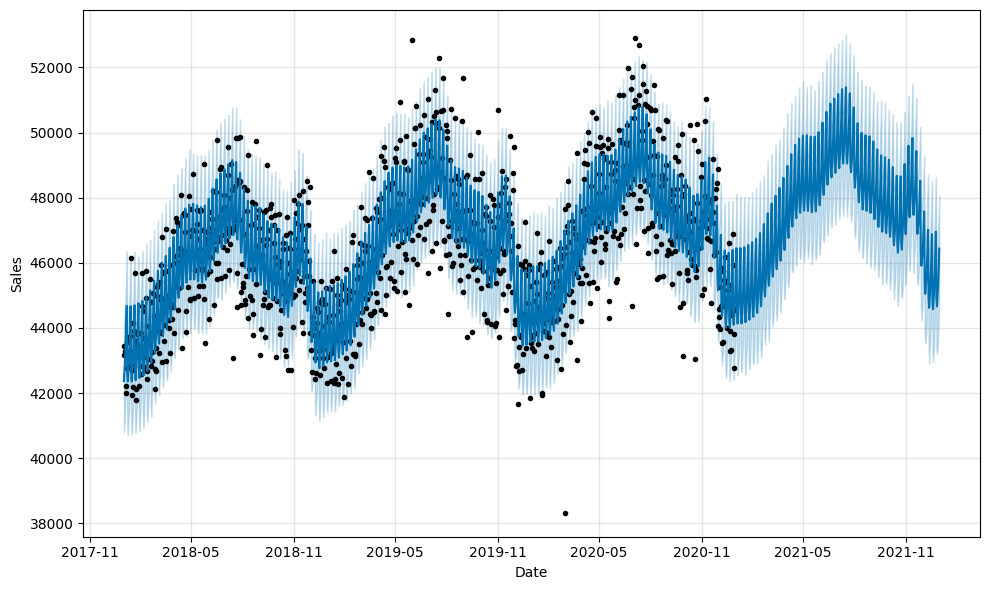

In [112]:
fig = m.plot(forecast, xlabel="Date", ylabel="Sales")

### Plotando componentes

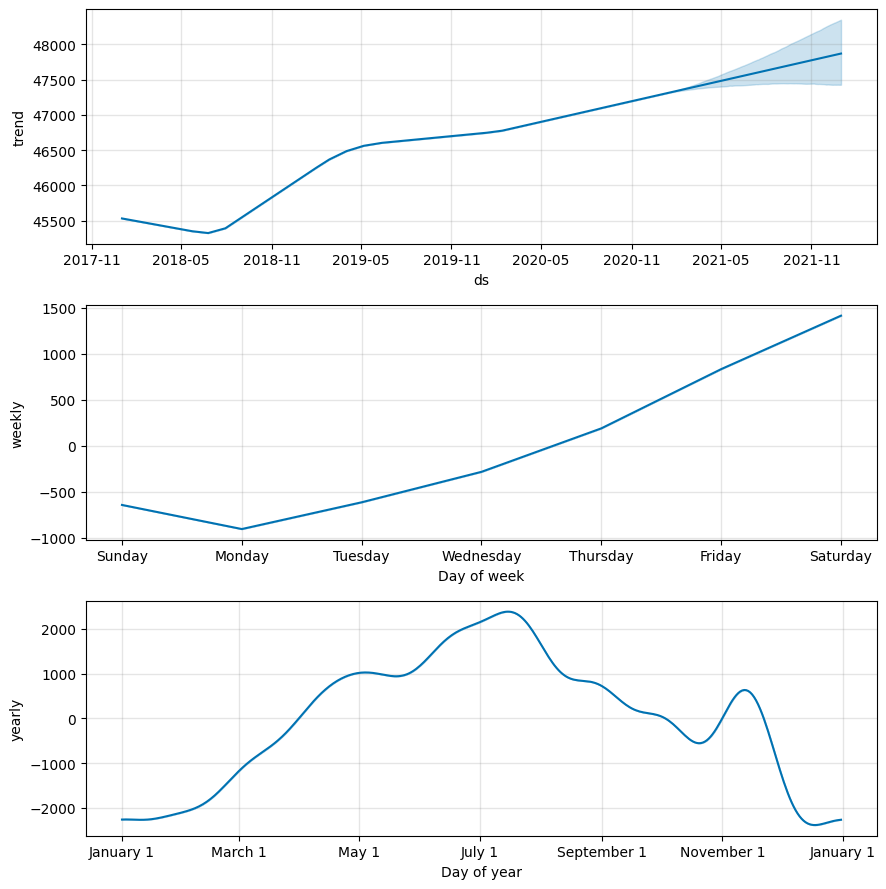

In [113]:
m.plot_components(forecast);

As componentes acima mostram um tendência de alta no período analisado. Além disso, parece que o intervalo de confiança está um pouco alto. Analisando os gráficos de sazonalidade, temos uma maior sazonalidade aos finais de semana se olharmos o gráfico semanal e durante o ano temos uma quantidade de vendas maior entre os mêses de Maio e setembro.

### Avaliando o modelo diário (Baseline)

### Validação cruzada

Validação cruzada (Cross Validation) é um procedimento muito útil para descobrir quais is melhores hyperparâmetros para nossos modelos de Machine Learning. Ele é muito utilizado em datasets onde não temos dados suficientes para criar os nossos sets de dados de treinamento (train), validação (validation) e testes (test).

Para mais detalhes sobre testes de modelos usando a validação cruzada, recomendo uma breve olhada no meu projeto de [Churn Prediction para uma empresa de Telecomunicações](https://bit.ly/3mqnbYn).

No entando, não podemos utilizar a validação cruzada da mesma forma como utulizamos para ajustar os hyperparâmetros em modelos que envolvem séries temporais (forecasting). Veja a imagem abaixo:


<center><img src="https://drive.google.com/uc?export=view&id=135YsGSow36McBzTdmB0FTu1qRDTRyFL3" width="100%"></p></center>

Perceba o eixo X onde temos as datas.

1. Na janela 0, os dados de teste ocorrem antes dos dados de treino;
2. Nas janelas 2 e 4, alguns dados de treino ocorrem depois dos dados de teste. Isto é problemático por que o modelo tem acesso a dados do futuro (data leakage)
3. Nas janelas 2 e 4, existem lacunas nos dados de treino visto que os dados de treino são tomados do meioda série.

De acordo com o [paper](https://peerj.com/preprints/3190.pdf) disponibilizado pela documentação do Prophet, é muito difícil de utilizar o método de validação cruzada com séries temporais por que a observações não podem ser misturadas.

```
We cannot simply randomly partition the data.
```

Sendo assim, é utilizado um procedimento clássico chamado *rolling origin* para a avaiação de modelos para modelos de séries temporais.

```
This procedure is based on classical “rolling origin” forecast evaluation procedures (Tashman 2000).
```

### Rolling origin

Quando há necessidade de selecionar um modelo de forecasting mais apropriado geralmente os dados são divididos em duas partes: um “conjunto de treinamento” e conjunto de teste". O modelo é então é treinado usando o conjunto de treinamento e seu desempenho de previsão é avaliado usando alguma medida de erro no conjunto de teste.

Caso este procedimento for feito apenas uma vez, então, chamamos isto de avaliação de “origem fixa” (fixed origin). No entanto, a série temporal pode conter valores discrepantes ou mudanças de nível e um modelo ruim pode ter um desempenho satisfatório em relação a modelos mais apropriados. Para avaliar o nosso modelo de uma forma mais robusta, utiliza-se algo chamado “origem rolante” (rolling origin).

A *rolling origin* é uma técnica de avaliação segundo a qual a origem da previsão é atualizada sucessivamente e as previsões são produzidas a partir de cada origem (Tashman 2000). Esta técnica permite obter diversos erros de previsão para séries temporais, o que permite uma melhor compreensão do desempenho dos modelos.

A imagem abaixo demostra a ideia básica da técnica *rolling origin*, onde, temos uma série temporal de 25 observações e as previsões são produzidas a partir de 8 origens, iniciando pela origem 15.

As células brancas correspondem aos dados de treino, enquanto que as células em cinza correspondem previsões (3 períodos a frente).

O modelo é re-treinado a cada iteração (origin) e as previsões são produzidas. Depois disso, uma nova observação é adicionada ao final da série e o procedimento continua. O processo para quando não há mais dados para adicionar.

Como resultado final deste procedimento, são produzidas 8 conjuntos de 3 períodos a frente de previsões, neles podemos avaliar o nosso modelo e escolher o modelo de melhor desempenho.

<center><img src="https://drive.google.com/uc?export=view&id=1A6c_QSCWtudzz60ZABQyVvVO2SW0JFGX" width="100%"></p></center>

### Validação cruzada com Prophet

O Prophet disponibiliza um pacote (```prophet.diagnostics```) onde podemos fazer a validação cruzada já evitando os problemas descritos acima. Este pacote possui uma classe chamada ```cross_validation```. Iremos utiliza-la para avaliarmos os nosso modelos.

Para entender melhor este procedimento de split dos dados, previsões etc, recomendo uma visita a [documentação do cross validation](https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation) e uma consulta as anotações do [código fonte](https://github.com/facebook/prophet/blob/e665430adcd7690a1ea7565803f34043596045fe/python/prophet/diagnostics.py#L61-L66).


In [114]:
# Neste exemplo iremos deixar os demais parâmetros como default e deixar que o Prophet cuide do split dos dados para avaliar o modelo
df_cv = cross_validation(m, horizon="180 days") # passamos como parâmetro nosso modelo diário e um horizonte de previsões de 180 dias

INFO:prophet:Making 5 forecasts with cutoffs between 2019-07-10 00:00:00 and 2020-07-04 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/jmg8nxyy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/wynoqy7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20214', 'data', 'file=/tmp/tmppxyz_nh6/jmg8nxyy.json', 'init=/tmp/tmppxyz_nh6/wynoqy7t.json', 'output', 'file=/tmp/tmppxyz_nh6/prophet_model4byd1hdm/prophet_model-20231031084422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/xw2evm8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/hlnzy362.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

O retorno do método ```cross_validation``` é um Pandas DataFrame contendo as previsões, o valores reais e as datas de cortes (```cutoff```). Percebam que cada ```cutoff``` possui um horizonte (```ds```) de 6 meses (180 dias)

In [115]:
df_cv.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-11,48932.604073,47683.900876,50092.807650,50513,2019-07-10
1,2019-07-12,49551.975651,48385.969849,50837.423339,51314,2019-07-10
2,2019-07-13,50142.293079,48942.555423,51362.962935,50618,2019-07-10
3,2019-07-14,47250.369213,45895.580171,48537.773400,46596,2019-07-10
4,2019-07-15,48233.777079,46902.767531,49438.407344,48252,2019-07-10
5,2019-07-16,48254.445132,46978.775715,49507.948975,48976,2019-07-10
6,2019-07-17,48814.985356,47581.804197,49995.586522,48322,2019-07-10
7,2019-07-18,49021.554044,47804.709738,50228.589393,50300,2019-07-10
8,2019-07-19,49624.866322,48430.607285,50851.415805,50127,2019-07-10
9,2019-07-20,50195.306691,48930.713699,51361.536938,52287,2019-07-10


O método ```cross_validation``` fez 5 split em nossos dados.



In [116]:
len(df_cv.cutoff.unique())

5

Cada data de corte possui um horizonte de 180 dias de predições, feitas pelo nosso modelo diário (```m```).

In [117]:
# lista de datas de corte (split dos dados)
for cutoff in list(df_cv.cutoff.unique()):
  print(cutoff)

2019-07-10T00:00:00.000000000
2019-10-08T00:00:00.000000000
2020-01-06T00:00:00.000000000
2020-04-05T00:00:00.000000000
2020-07-04T00:00:00.000000000


#### Avaliando valores reais VS previsões

In [118]:
# criando uma cópia do dataframe df_cv
df_diff = df_cv.copy()

# calculando as diferenças entre y e yhat
df_diff["diff"] = abs(df_diff["y"] - df_diff["yhat"])

# imprimindo as estatísticas descritivas
df_diff.describe()

,yhat,yhat_lower,yhat_upper,y,diff
count,900.000000,900.000000,900.000000,900.000000,900.000000
mean,46860.460283,45519.716626,48208.033628,46900.113333,1213.634088
std,1538.787359,1527.042778,1557.526616,2208.141264,1119.799401
min,42608.452133,41288.420520,43925.861655,38322.000000,0.724826
25%,45852.334213,44509.299491,47196.723527,45376.750000,421.483660
50%,46983.018453,45591.618416,48332.952635,46808.000000,921.290130
75%,47976.576441,46645.110341,49338.416012,48420.000000,1617.236441
max,50624.929804,49097.266566,52115.649594,52901.000000,9053.841625


Com o método ```decribe``` conseguimos as seguintes informações sobre as nossas precisões:

1. A diferença média entre ``y`` e ``yhat`` é de 1213;
2. A diferença mínima encontrada foi de 0.72;
3. A diferença máxima encontrada foi de 9053;

A primeiro momento esta diferença pode ser grande porém, olhando o nosso y médio (média de vendas diárias), temos um valores de 46900, ou seja, nosso modelo está com erro pequeno.

Abaixo podemos ver este erro aplicando o método ```performance_metrics```.

#### Métricas de performance

In [119]:
# calculando as métricas de performace
df_p = performance_metrics(df_cv)

# imprimindo as 20 primeiras linhas
df_p.head(20)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,1.951267e+06,1396.877513,1028.326198,0.021329,0.015200,0.021545,0.733333
1,19 days,1.675687e+06,1294.483353,978.644020,0.020417,0.015168,0.020559,0.733333
2,20 days,1.630928e+06,1277.077774,961.037866,0.020030,0.014344,0.020183,0.755556
3,21 days,1.901711e+06,1379.025430,1024.679064,0.021315,0.015168,0.021507,0.722222
4,22 days,2.091197e+06,1446.097273,1101.570921,0.022963,0.017014,0.023160,0.677778
5,23 days,2.124742e+06,1457.649445,1121.074278,0.023393,0.017510,0.023574,0.666667
6,24 days,2.172325e+06,1473.880764,1116.306048,0.023244,0.017014,0.023439,0.677778
7,25 days,2.010064e+06,1417.767395,1077.021494,0.022532,0.016149,0.022662,0.688889
8,26 days,1.857978e+06,1363.076794,1030.668553,0.021624,0.014997,0.021715,0.711111
9,27 days,1.871967e+06,1368.198567,1047.467348,0.021937,0.016149,0.022047,0.711111


Aplicando o método ```describe()``` sobre o dataframe ```df_p```, retornado pelo método ```performance_metrics``` podemos ver alguma estatísticas descritivas do nosso modelo diário.

Aqui vamos tomar como analise a métrica MAPE (*Mean Absolute Percentage Error*), que é a diferença absoluta entre a previsão (*yhat*) e a observação real (*y*), retornando uma medida em porcentagem.

Uma breve explicação sobre métricas de regressão podem sem encontradas neste [projeto](https://github.com/lstarke/Health-Insurance-Cost-Prediction).

In [120]:
# calculando estatísticas descritivas sobre o DataFrame contendo as métricas
df_p.drop("horizon", axis=1).describe()

,mse,rmse,mae,mape,mdape,smape,coverage
count,1.630000e+02,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,2.702727e+06,1632.660032,1203.439588,0.025607,0.019410,0.025659,0.666735
std,6.274388e+05,193.332527,132.913145,0.003068,0.002900,0.002995,0.042418
min,1.570061e+06,1253.020841,936.989411,0.019791,0.012748,0.019837,0.555556
25%,2.144370e+06,1464.351579,1103.770352,0.023040,0.017308,0.023212,0.633333
50%,2.762409e+06,1662.049582,1215.513221,0.025784,0.019224,0.025887,0.666667
75%,3.080291e+06,1755.075630,1288.615857,0.027657,0.021730,0.027692,0.700000
max,4.213061e+06,2052.574274,1523.099089,0.033451,0.025320,0.033127,0.755556


Alguns pontos relevantes sobre as métricas obtidas:

* Podemos ver que a MAPE ficou com uma média de 2,5%, isso que dizer que nossas previsões em médias ficaram 2,5% afastadas (em média) da nossa observação real;
* 75% das previsões tiveram um afastamento da observação real de 2,7%;



# Série estacionária

Nesta etapa iremos transformar uma TS em estacionária, precisamos remover a tendência e a sazonalidade que há nos dados originais.

Uma das técnicas utilizadas é aplicar o $log$ a fim de reduzir a magnitude dos valores da TS. Na sequência, subtraímos a média móvel de um determinado período em relação ao $log$ da TS.

Vamos ver como o nosso modelo se sai com estas tranformações!

In [121]:
# somando a quantidade de vendas por dia
df_prophet_daily = df_prophet.resample("D").sum().reset_index()

# renomeando as colunas date e sales para ds e y respectivamente
# esta alteração é necessária para a utilização do Prophet
df_prophet_daily.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

# setando a coluna DateTime como index do DataFrame
df_prophet_daily.set_index("ds", inplace=True, drop=True)

#imprimindo 20 primeiros registros
df_prophet_daily.head()

,y
ds,
2018-01-01,43432
2018-01-02,43181
2018-01-03,43298
2018-01-04,42216
2018-01-05,42001


### Aplicando média móvel

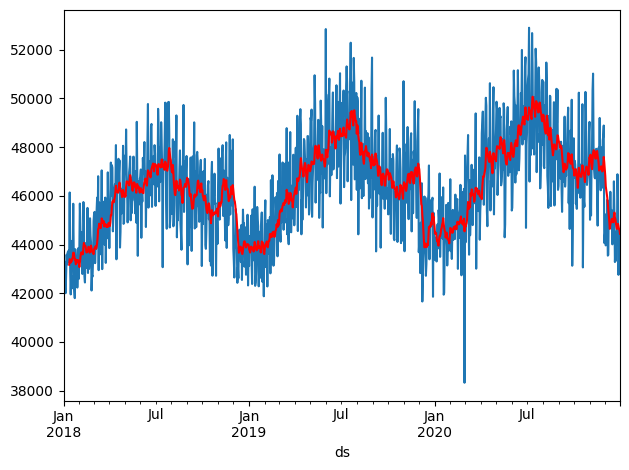

In [122]:
# calculando a média aritmética móvel de 12 dias
ma = df_prophet_daily.rolling(12).mean()

# plotando gráfico com dados originais e a média móvel
fig, ax = plt.subplots();
df_prophet_daily.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color="r")
plt.tight_layout()

### Aplicando log

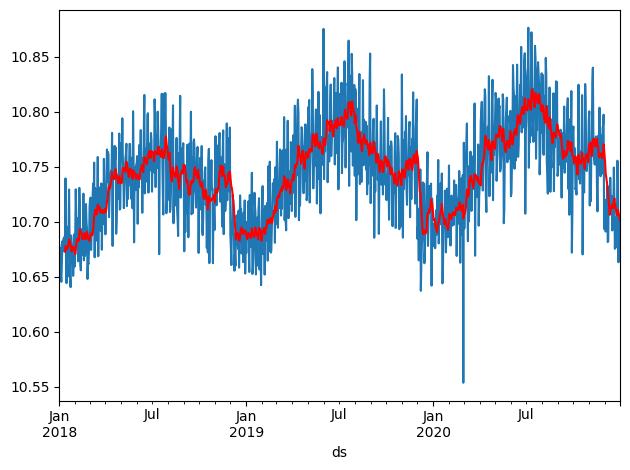

In [123]:
# aplicando log
df_prophet_daily_log = np.log(df_prophet_daily)
ma_log = df_prophet_daily_log.rolling(12).mean()

# plotando gráfico
fig, ax = plt.subplots();
df_prophet_daily_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color="r")
plt.tight_layout()

Veja como reduzimos a escala do eixo Y aplicando o $log$ facilitando o trabalho a partir de agora.

Aplicar o *log* é interessante quando é identificado que temos uma tendência que é exponencial.

### Eliminando a tendência

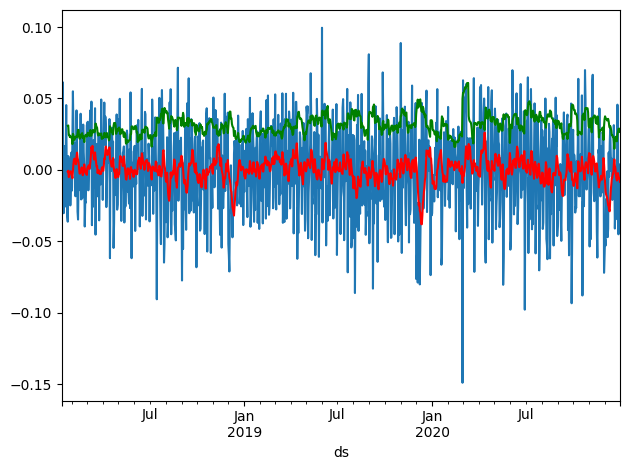

In [124]:
df_sub = (df_prophet_daily_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
std_sub = df_sub.rolling(12).std()

# plotando gráfico
fig, ax = plt.subplots();
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, legend=False, color="r")
std_sub.plot(ax=ax, legend=False, color="g")
plt.tight_layout()

Compare visualmente o gráfico acima com o anterior, veja como não temos mais uma tendência de alta e o gráfico está constante ao longo do tempo.

Aqui estamos subtraindo a média móvel da observação da própria observação, eliminando a tendência e destacando as variações de curto prazo nos dados. Esta técnica é chamada de "diferenciação de média móvel" ou "Média Móvel Diferenciada" (em inglês, "Moving Average Differencing"), facilitando a modelagem e a previsão de padrões sazonais e irregulares.

## Repetindo teste de Dickey-Fuller Aumentado (ADF)

In [125]:
# extrair apenas os valores do dataframe
X = df_sub.y

# aplicar o ADF
result = adfuller(X)

# imprimindo o resultado
print(f"Teste estatístico: {result[0]:.4f}")
print(f"p-value: {result[1]:.10f}")
print(f"Valores críticos:")
for key, value in result[4].items():
   print(f"\t{key}: {value:.4f}")

Teste estatístico: -6.8574
p-value: 0.0000000016
Valores críticos:
	1%: -3.4365
	5%: -2.8643
	10%: -2.5682


Veja como reduzimos o p-value, com isso aumentamos o nível de confiança para considerar que nossa série temporal é estacionária!

## Diferencição

Uma outra técnica simples que ajuda a tornar TS mais estácionária é a diferenciação (subtrair uma coisa pela outra).

Apenas calculando a diferença entre duas observações possíveis, é possível incrementar ainda mais o desempenho no ADF.

$$value(t) = observation(t) - observation(t -1)$$

### DataFrame.diff()

O método `diff()` calcula a diferença entre o valor atual e o valor anterior ao longo do eixo especificado. Ele retorna uma nova série ou DataFrame contendo essas diferenças. Essa função é útil quando se deseja calcular a variação entre valores consecutivos em um conjunto de dados.

<center><img src="https://www.w3resource.com/w3r_images/pandas-dataframe-diff-1.svg" width="50%"></center>

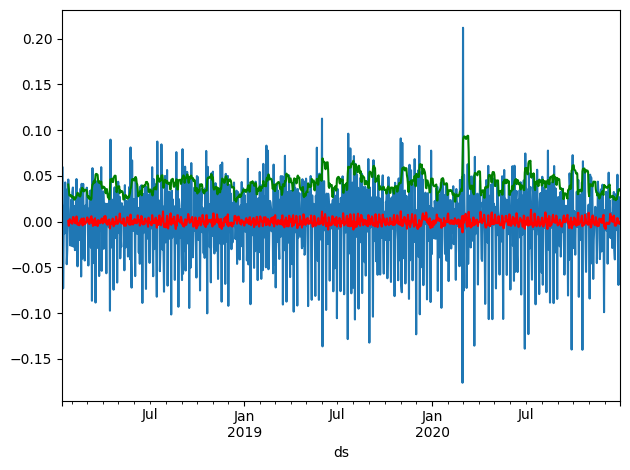

In [126]:
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

# plotando gráfico
fig, ax = plt.subplots();
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color="r")
std_diff.plot(ax=ax, legend=False, color="g")
plt.tight_layout()

Nossa média muito mais estabilizada.

### Repetindo teste de Dickey-Fuller Aumentado (ADF)

Agora sobre a diferenciaçao.

In [127]:
X = df_diff.y.dropna().values

# aplicar o ADF
result_diff = adfuller(X)

# imprimindo o resultado
print(f"Teste estatístico: {result_diff[0]:.4f}")
print(f"p-value: {result_diff[1]:.10f}")
print(f"Valores críticos:")
for key, value in result_diff[4].items():
   print(f"\t{key}: {value:.4f}")

Teste estatístico: -15.5338
p-value: 0.0000000000
Valores críticos:
	1%: -3.4365
	5%: -2.8643
	10%: -2.5682


Veja como o valor do teste estatístico diminuiu ainda mais.

Vamos seguir adiante e testar agora a nossa serie tranformada e ver como ele se sai nas previsões!

# Re-treinando o modelo com a serie transformada

In [128]:
df_prophet_daily_log.reset_index(inplace=True)

df_prophet_daily_log.head()

,ds,y
0,2018-01-01,10.678952
1,2018-01-02,10.673156
2,2018-01-03,10.675862
3,2018-01-04,10.650555
4,2018-01-05,10.645449


In [129]:
# instanciando um objeto/modelo Prophet
m = Prophet()

# treinar nosso modelo com os dados
m.fit(df_prophet_daily_log)

# fazendo previsões para 365 dias no futuro
future = m.make_future_dataframe(periods=365)

# fazendo previsões para o período de 365 dias
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/8eufif5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/27l0rvud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43106', 'data', 'file=/tmp/tmppxyz_nh6/8eufif5s.json', 'init=/tmp/tmppxyz_nh6/27l0rvud.json', 'output', 'file=/tmp/tmppxyz_nh6/prophet_modelar7jpena/prophet_model-20231031084434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


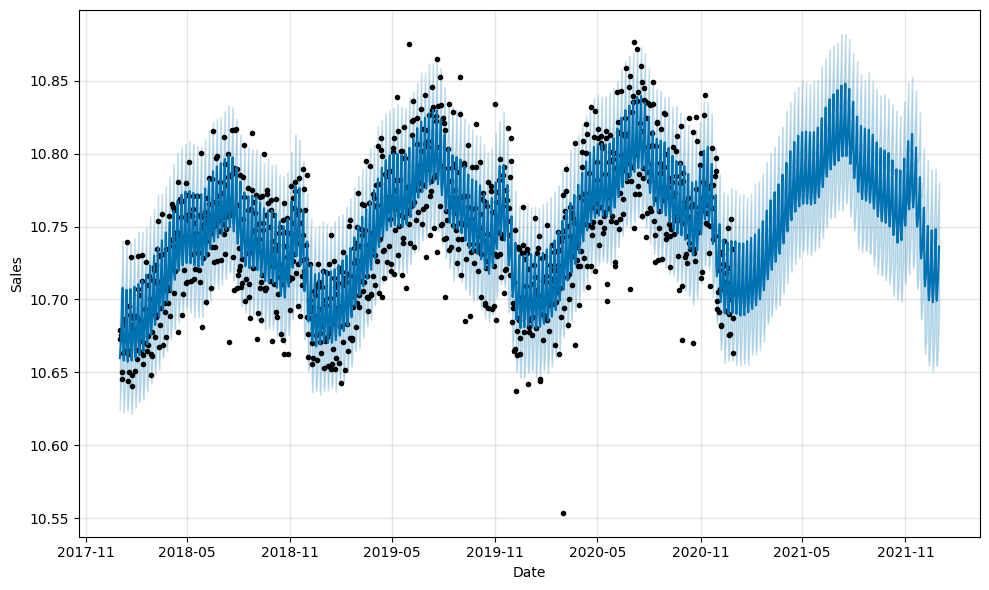

In [130]:
fig = m.plot(forecast, xlabel="Date", ylabel="Sales")

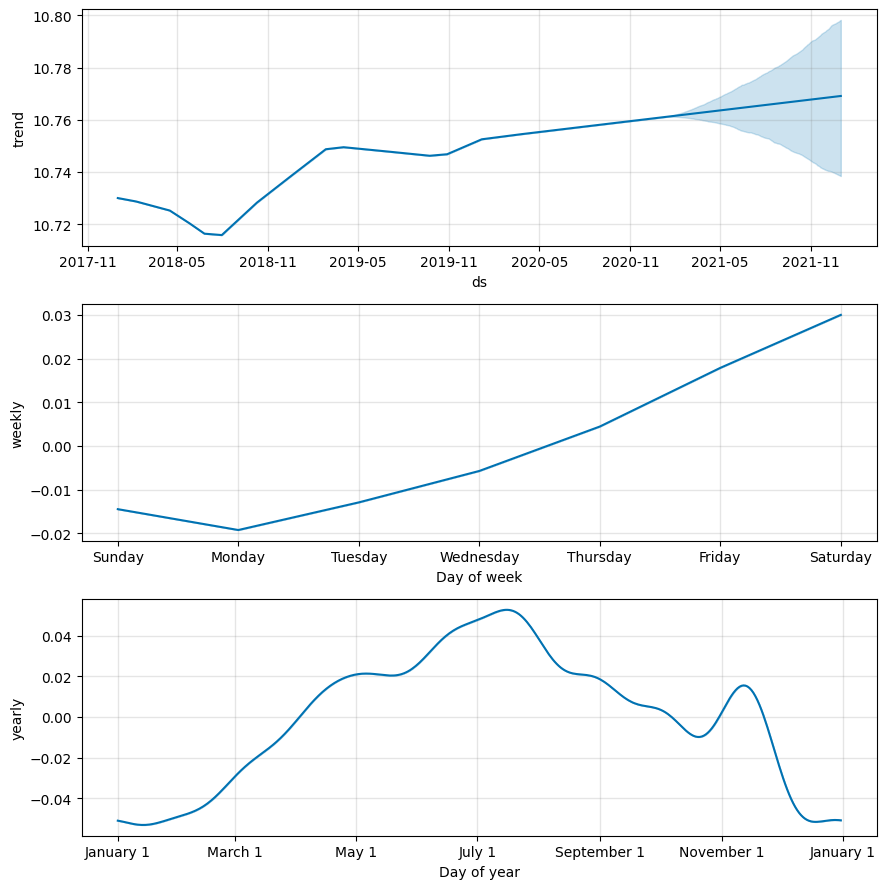

In [131]:
m.plot_components(forecast);

## Validando o modelo

In [132]:
# criando dataframe para armazenar as previsões e fazer a validação cruzada
df_cv = cross_validation(m, horizon="180 days")

# calculando as métricas de performace
df_p = performance_metrics(df_cv)

# calculando estatísticas descritivas sobre o DataFrame contendo as métricas
df_p.drop("horizon", axis=1).describe()

INFO:prophet:Making 5 forecasts with cutoffs between 2019-07-10 00:00:00 and 2020-07-04 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/zs8qq_wi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/ami__60f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49685', 'data', 'file=/tmp/tmppxyz_nh6/zs8qq_wi.json', 'init=/tmp/tmppxyz_nh6/ami__60f.json', 'output', 'file=/tmp/tmppxyz_nh6/prophet_model63czzn1s/prophet_model-20231031084439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/vwn46t0p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/hyqxjxq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,mse,rmse,mae,mape,mdape,smape,coverage
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,0.001165,0.033892,0.024967,0.002320,0.001756,0.002322,0.691820
std,0.000272,0.004045,0.002713,0.000254,0.000276,0.000254,0.046748
min,0.000644,0.025387,0.018893,0.001754,0.001194,0.001755,0.600000
25%,0.000983,0.031347,0.023406,0.002173,0.001598,0.002175,0.655556
50%,0.001189,0.034487,0.025253,0.002352,0.001780,0.002351,0.677778
75%,0.001348,0.036717,0.026585,0.002470,0.001937,0.002472,0.722222
max,0.001774,0.042119,0.031785,0.002959,0.002333,0.002961,0.811111


Olhando para a métrica MAPE, tivermos uma melhora significativa de 2,5% para 0,2% comparando com os resultados da nossa validação cruzada da nossa baseline ou seja, as previsões do novo modelo ficaram afastados dos valores reais apenas 0,2%.

Criando um dataframe final com todas as informações necessárias:

In [134]:
# criando um dataset completo
df_final = forecast[['ds', 'yhat']]
df_final['AmountSalesLog'] = df_prophet_daily_log['y']

# convertendo os valores devolta para a escala original
df_final['AmountSales'] = np.exp(df_final['AmountSalesLog'].values)
df_final['AmountSalesPred'] = np.exp(df_final['yhat'].values)

# imprimindo os 5 primeiros registros
df_final.head()

,ds,yhat,AmountSalesLog,AmountSales,AmountSalesPred
0,2018-01-01,10.659838,10.678952,43432.0,42609.752645
1,2018-01-02,10.665974,10.673156,43181.0,42872.000621
2,2018-01-03,10.672956,10.675862,43298.0,43172.368258
3,2018-01-04,10.682895,10.650555,42216.0,43603.601920
4,2018-01-05,10.696094,10.645449,42001.0,44182.935000


Acima podemos ver o nosso dataframe final onde temos as seguintes informações:

1. `yhat`: Log das previsões da quantidade de vendas;
2. `AmountSalesLog`: Log da quantidade de vendas (real);
3. `AmountSales`: Quantidade de vendas (real);
4. `AmountSalesPred`: Previsões da quantidade de vendas.

## Modelo semanal

Nesta sessão será usado o dataframe com os dados agrupados semanalmente. Dependendo do contexto criar uma modelo de forecasting para estimar um determinado valor para um único dia pode ser uma tarefa difícil.

Aumentar esta frequencia geralmente faz mais sentido nestes casos e pode melhorar a precisão do modelo de forecasting.

In [62]:
# Somando todas as vendas realizadas em 1 dia
df_prophet_weekly = df_prophet.resample("W").sum()

df_prophet_weekly.head()

,sales
date,
2018-01-07,300477
2018-01-14,306573
2018-01-21,304180
2018-01-28,300188
2018-02-04,307175


In [63]:
df_prophet_weekly.reset_index(inplace=True)
df_prophet_weekly.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

In [64]:
# instanciando um objeto/modelo Prophet
m_weekly = Prophet()

# treinar nosso modelo com os dados
m_weekly.fit(df_prophet_weekly)

# fazendo previsões para 365 dias no futuro
future = m_weekly.make_future_dataframe(periods=365)

# fazendo previsões para o período de 365 dias
forecast = m_weekly.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/nr4oeju_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/uaze17ep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73612', 'data', 'file=/tmp/tmppxyz_nh6/nr4oeju_.json', 'init=/tmp/tmppxyz_nh6/uaze17ep.json', 'output', 'file=/tmp/tmppxyz_nh6/prophet_modelsq2456ol/prophet_model-20231031081356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:13:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:13:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Plot de forecasting

do modelo semanal

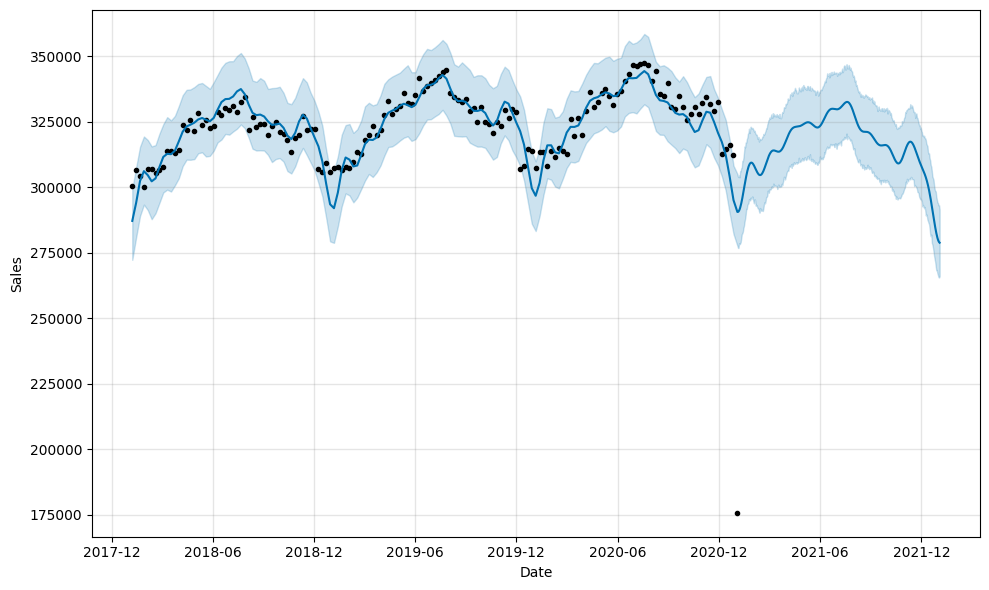

In [65]:
fig = m_weekly.plot(forecast, xlabel="Date", ylabel="Sales")

### Plotando componentes

do modelo semanal

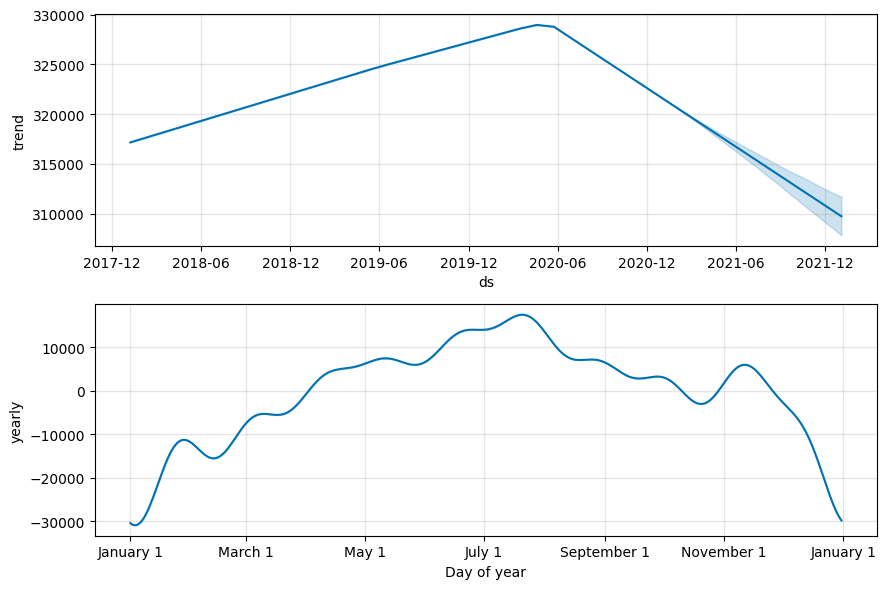

In [66]:
m_weekly.plot_components(forecast);

### Avaliando o modelo semanal

In [67]:
# criando o dataframe para fazer a validação cruzadas com um horizonte de 180 dias
df_cv_weekly = cross_validation(m_weekly, horizon="180 days")

# calculando as métricas de performace
df_cv_weekly = performance_metrics(df_cv_weekly)

# calculando estatísticas descritivas sobre o DataFrame contendo as métricas
df_cv_weekly.drop("horizon", axis=1).describe()

INFO:prophet:Making 5 forecasts with cutoffs between 2019-07-13 00:00:00 and 2020-07-07 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/5kf77zbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/dx47hr9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62072', 'data', 'file=/tmp/tmppxyz_nh6/5kf77zbo.json', 'init=/tmp/tmppxyz_nh6/dx47hr9r.json', 'output', 'file=/tmp/tmppxyz_nh6/prophet_model0pwiukh5/prophet_model-20231031081358.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:13:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:13:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/tjn0psbx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxyz_nh6/oq6h7365.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

,mse,rmse,mae,mape,mdape,smape,coverage
count,1.180000e+02,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,4.637546e+07,5797.125638,4749.128865,0.014708,0.013093,0.014537,0.433507
std,1.453526e+08,3588.582630,1819.229944,0.007529,0.004173,0.006253,0.195965
min,5.679490e+06,2383.167976,2138.104604,0.006470,0.005196,0.006474,0.153846
25%,1.817570e+07,4257.571532,3220.125457,0.009780,0.009094,0.009785,0.307692
50%,3.375770e+07,5810.097776,5071.706893,0.015333,0.013769,0.015323,0.384615
75%,4.592491e+07,6776.688313,5671.804223,0.017146,0.015287,0.017162,0.596154
max,1.600392e+09,40004.899192,17010.622177,0.080584,0.022463,0.062819,0.846154


Perceba a queda da média da métrica MAPE, tivemos uma redução de 2,5% (do modelo diário) para 1,4% (do modelo semanal). Além disso tivemos uma redução na no intervalo de confiança de olharmos a tendência nos gráficos de componentes.

# Considerações finais

Neste projeto foi possivel ver na prática como um framework como o Prophet pode simplificar e acelerar a construção de um modelo de forcasting, abtraindo várias etapas e conhecimento sobre séries temporais necessárias para a construção desses modelos.

Sendo assim, vale destacar alguns recursos do Prophet usados durante o desenvolvimento deste projeto:

1. **Criação e treinamento do modelo**: O Prophet foi projetado para que seja fácil de usar requerendo o mínimo de ajustes possível. Em apenas duas linhas de código criamos o modelos e fazemos o treinamento.
2. **Previsões futuras**: Novamente nesta etapa vimos como a interface amigável do Prophet ajuda para realizar a previsões futuras. Em conjunto com o método ``make_future_dataframe`` fica fácil para as etapas seguintes analisar as previsões e medir a performance do modelo.
3. **Flexibilidade com dados ausentes**: Vimos na documentação como o Prophet lida muito bem com dados ausentes, outliers e lacunas na série temporal.
4. **Gráficos de analise**: De forma fácil é possivel plot gráficos para verificar como as previsões se comportam no periodo futuro especificado. Alem disso temos a possibilidade de plotar gráficos de componentes de tendência e sazonalidade.

O Prophet vai muito alem das funcionalidades exploradas neste projeto projeto simples, sendo amplamente utilizado hoje pela comunidade de análise de dados devido a dua eficácia e facilidade no uso.

# Referências



* https://github.com/gabrielmartini1/Vinhos_com_Series_Temporais/blob/main/Previs%C3%A3o_de_Demanda_de_Vinhos_com_S%C3%A9ries_Temporais.ipynb
* https://medium.com/@josesalesjdsj/previs%C3%A3o-de-demanda-com-prophet-a083eb1e80af
* https://facebook.github.io/prophet/docs/non-daily_data.html
* https://medium.com/swlh/forecasting-an-intermittent-time-series-1461de7616fe
* https://stats.stackexchange.com/questions/8779/analysis-of-time-series-with-many-zero-values
* https://github.com/sujikathir/Intermittent-demand-forecasting
* https://towardsdatascience.com/forecasting-intermittent-time-series-in-python-9fd028a0c9ee
* MANCUZO, A. C. B.; WERNER, L. Estudo dos métodos de previsão de demanda aplicado em uma empresa de
auditorias médicas. Revista Ingienería Industrial. p. 99-111, abr. 2014.
* https://medium.com/ensina-ai/princ%C3%ADpios-b%C3%A1sicos-para-criar-previs%C3%B5es-de-s%C3%A9ries-temporais-e58c451a25b
* https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711
* https://people.duke.edu/~rnau/411home.htm
* https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c



# LAG

Para ter previsibilidade uma série com uma única variável deve ser auto correlacionada, ou seja, o período atual deve ter explicação com base em um período anterior (lag).